# 作业内容：

> 1，要做大量 $\pi^0$ 介子的分子动力学模拟，如果温度为 $T=150 $ MeV, 尝试抽取 1000 个 $\pi^0$ 介子的四动量 $k^{\mu} = (E, k_x, k_y, k_z)$。

>> 注意：$\pi^0$ 介子是玻色子，质量 $m=135$ MeV, 动量的绝对值 $k=\sqrt{k_x^2 + k_y^2 + k_z^2}$ 满足玻色爱因斯坦分布函数，

>>\begin{align}
f(k) = {1 \over e^{\sqrt{k^2 + m^2} / T} - 1}
\end{align}

>> 提示：先抽取动量的绝对值 k，然后赋予动量方向（$4\pi$ 角内均匀分布）得到极角 $\theta$ 和方位角 $\phi$, 然后转化为笛卡尔坐标下,

>>\begin{align}
k_x & = k \cos(\theta) \sin(\phi) \\
k_y & = k \cos(\theta) \cos(\phi) \\
k_z & = k \sin(\theta) \\
E &= \sqrt{m^2 + k_x^2 + k_y^2 + k_z^2}
\end{align}

> 2，定义指标来评估模拟结果是否正确

# 参考答案


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
def sampling(func, range_=[[0, 1], [0, 1]], n=1000):
    r'''
    Monte-Carlo sampling.
    Args: 3
        func: a function, the pdf. to be sampled.
        range_: a list, [[xmin, xmax], [ymin, ymax]].
        n: an integer, how many variables you want to simulate.
    Return: 1
        res: an array with n variables respect to the pdf. func.
    '''
    [xmin, xmax], [ymin, ymax] = range_
    samples = np.zeros(n, dtype=np.float32)
    i = 0
    while i < n:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        if y < func(x):
            samples[i] = x
            i = i + 1
    return samples

def samplingV2(func, range_=[[0, 1], [0, 1]], n=1000, alpha=100):
    r'''
    Monte-Carlo sampling. version 2.
    Args: 4
        func: a function, the pdf. to be sampled.
        range_: a list, [[xmin, xmax], [ymin, ymax]].
        n: an integer, how many variables you want to simulate.
        alpha: an int, generate alpha times of n variables candidates for one time.
    Return: 1
        res: an array with n variables respect to the pdf. func.
    '''
    [xmin, xmax], [ymin, ymax] = range_
    res = np.array([])
    while len(res) < n:
        x = np.random.uniform(xmin, xmax, (alpha*n,))
        y = np.random.uniform(ymin, ymax, (alpha*n,))
        f = func(x)
        res_tmp = x[f>y]
        res = np.concatenate((res, res_tmp))
    res = res[:n]
    return res

In [3]:
#define the raw distribution of k
def raw_func(k, m=135, T=150):
    return k**2 /(np.exp((k**2 + m**2)**0.5 /T) - 1)

#calculate the normalization constant
amplitude, _ = quad(raw_func, 0, 1500, (135, 150))

#get the normalized distribution
def func(k, m=135, T=150):
    global amplitude
    return raw_func(k, m, T) / amplitude

#check
k0 = np.linspace(0, 1500, 150)
pk0 = func(k0)
pmax = pk0.max()
pmin = pk0.min()
print('Amplitude: {}'.format(amplitude))
print('Maximum of p(k): {}'.format(pmax))
print('Minimum of p(k): {}'.format(pmin))

Amplitude: 6253122.113763517
Maximum of p(k): 0.0018086460298166697
Minimum of p(k): 0.0


抽样k，$\theta$和$\phi$时，注意到：

$$p(\vec k)d\vec k = K(k)\Theta(\theta)\Phi(\phi)k^2\sin(\theta)dkd\theta d\phi$$

把它们分成3个部分：

$$ p(k)dk = K(k)k^2dk $$

$$ p(\theta)d\theta = \Theta(\theta)\sin(\theta)d\theta $$

$$ p(\phi)d\phi = \Phi(\phi)d\phi $$

已知$K(k) = {1 \over e^{\sqrt{k^2 + m^2} / T} - 1}$，所以抽样k遵循：

$$ p(k)dk = A{k^2 \over e^{\sqrt{k^2 + m^2} / T} - 1}dk $$

A是归一化常数，对不带A的部分做全空间积分，取倒数即可求得A。

而对方位角和极角而言，本身的分布是因为各向同性而均匀分布的，所以抽样$\theta$遵循：

$$ p(\theta)d\theta = \sin(\theta)d\theta $$

注意到这个其实等价于$  d\cos(\theta) $也就是对$\cos(\theta)$做均匀分布的抽样，恰好，我们需要用到计算动量分量的也是$\theta$的正弦和余弦值，利用公式$\sin^2 x + \cos^2 x = 1$，在$[0, \pi]$区间上，正弦值恒为正，所以这里可以取巧，直接抽样$\cos(\theta)$然后算$\sin(\theta)=\sqrt{(1-\cos(\theta)}$

对$\phi$的抽样最简单，直接在$[0, 2\pi]$上做均匀分布的抽样即可。

In [4]:
#simulate k, theta and phi
n = 100000
k = sampling(func, [[0, 1500], [pmin, pmax]], n=n)
cos_theta = np.random.uniform(-1, 1, (n,))
sin_theta = np.sqrt(1 - cos_theta**2)
phi = np.random.uniform(0, 2*np.pi, (n,))

Text(0.5, 1.0, 'k')

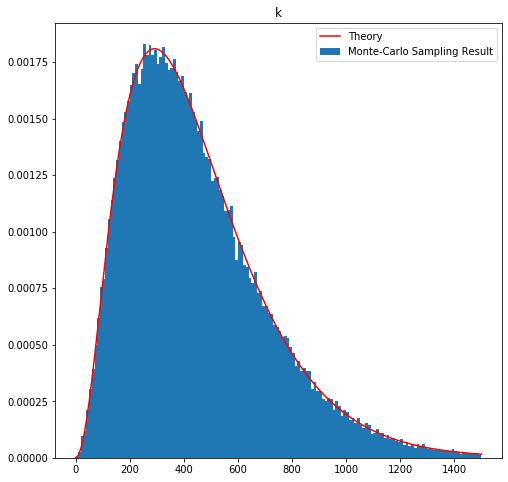

In [5]:
#check k
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.plot(k0, pk0, 'r-', label='Theory')
ax.hist(k, bins=150, range=(0, 1500), density=True, label='Monte-Carlo Sampling Result')
ax.legend()
ax.set_title('k')

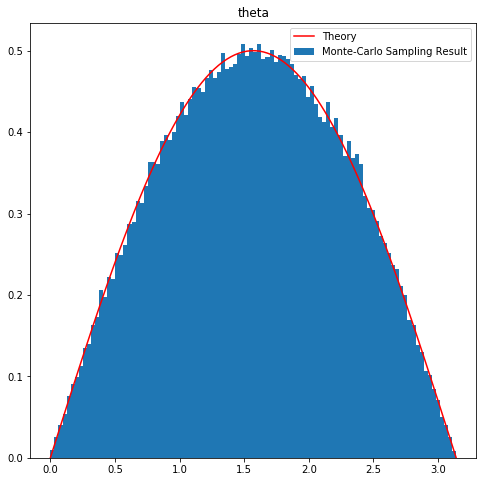

In [6]:
#check theta
theta0 = np.linspace(0, np.pi, 100)
ptheta0 = np.sin(theta0) * 0.5#note that, there is an amplitude as well, and we can easily know it is 0.5
ax.cla()
ax.plot(theta0, ptheta0, 'r-', label='Theory')
ax.hist(np.arccos(cos_theta), bins=100, range=(0, np.pi), density=True, label='Monte-Carlo Sampling Result')
ax.legend()
ax.set_title('theta')
fig

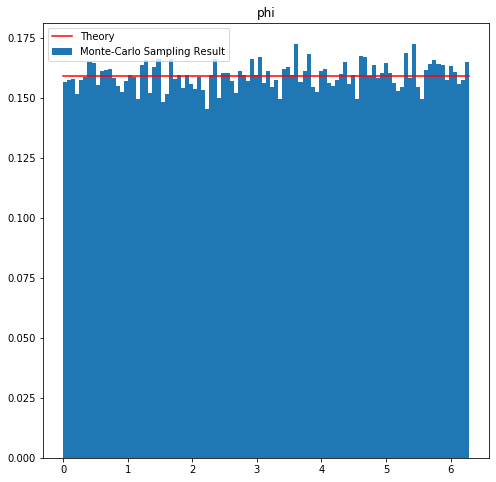

In [7]:
#check phi
phi0 = np.linspace(0, 2*np.pi, 100)
pphi0 = np.ones_like(phi0) * 1/(2*np.pi)
ax.cla()
ax.plot(phi0, pphi0, 'r-', label='Theory')
ax.hist(phi, bins=100, range=(0, 2*np.pi), density=True, label='Monte-Carlo Sampling Result')
ax.legend()
ax.set_title('phi')
fig

In [8]:
#compute kx, ky and kz
kx = k * sin_theta * np.cos(phi)
ky = k * sin_theta * np.sin(phi)
kz = k * cos_theta

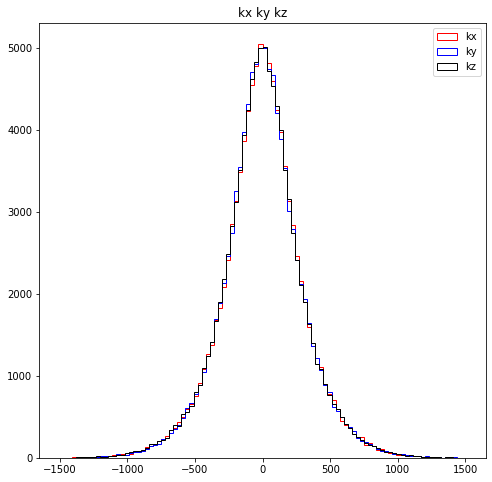

In [9]:
#check
ax.cla()
ax.hist(kx, bins=100, range=(-1500, 1500), color='red', histtype='step', label='kx')
ax.hist(ky, bins=100, range=(-1500, 1500), color='blue', histtype='step', label='ky')
ax.hist(kz, bins=100, range=(-1500, 1500), color='black', histtype='step', label='kz')
ax.legend()
ax.set_title('kx ky kz')
fig

可以同样画出E的理论分布与采样结果，需要一点基础的概统知识

设有随机变量X的分布为$f(x)$，有另一随机变量Y与单值函数$y=y(x)$使$Y=y(X)$，那么可以通过如下公式得到该随机变量Y的分布：

$$ g(Y) = f(y^{-1}(Y)) {y^{-1}}'(Y) $$

这里的$y^{-1}$指反函数，例如由$E(k) = \sqrt{m^2 + k^2}$，有$k(E) = \sqrt{E^2 - m^2}$

放到这里的实际问题中，显然有：

$$ g(E) = p(k(E))\frac{\partial k}{\partial E} $$

$$= A'{k^2 \over e^{\sqrt{k^2 + m^2} / T} - 1} \frac{E}{\sqrt{E^2 - m^2}}$$

$$= A'{E^2 - m^2 \over e^{E / T} - 1} \frac{E}{\sqrt{E^2 - m^2}}$$

$$= A' \frac{E\sqrt{E^2 - m^2}}{e^{E / T} - 1}$$

同样，$A'$也是归一化系数，可以积分后算出来

In [10]:
#check E
def raw_funcE(E):
    T = 150
    m = 135
    return E*np.sqrt(E**2 - m**2) /(np.exp(E/T) - 1)

amplitudeE, _  = quad(raw_funcE, 135, 4000)

def funcE(E):
    global amplitudeE
    return raw_funcE(E) / amplitudeE
print('Amplitude: {}'.format(amplitudeE))

Amplitude: 6271146.7848211


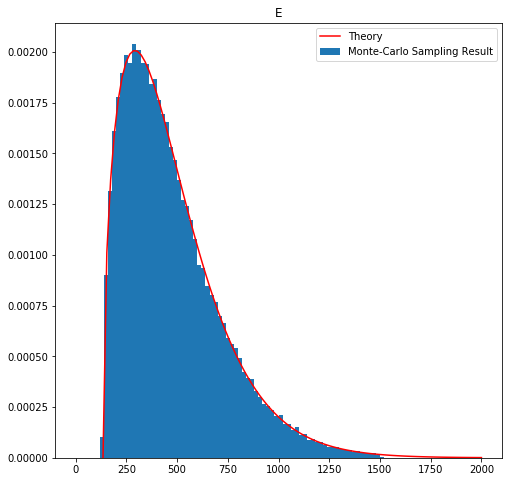

In [11]:
energy = np.sqrt(k**2 + 135**2)#135 for mass0
energy0 = np.linspace(135, 2000, 100)
pe = funcE(energy0)
ax.cla()
ax.plot(energy0, pe, 'r-', label='Theory')
ax.hist(energy, bins=100, range=(0, 2000), density=True, label='Monte-Carlo Sampling Result')
ax.legend()
ax.set_title('E')
fig